Second part of laboratories were conducted by <a href="https://github.com/jarek-pawlowski">Jarosław Pawłowski</a>. He created notebooks we used in laboratories. I am really glad that I had him as a tutor.

In second course of ML/AI we were build ML models using pytorch.

In this notebook I will present only some task we had as a homework from notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction)
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 50
# logging frequency
model_args['log_interval'] = 100

In [3]:

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data/', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('./data/', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



In [4]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

In [5]:
class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        # 4 kernels of size 5x5
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 4 feature maps each of size 8x8
        # x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2) # downsizing each map to 4x4
        x = F.relu(x)
        # fully connected layers
        x = x.view(-1, 64) # 4 maps of 4x4 size gives 64 numbers
        x = self.fc1(x) # 64 -> 20
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc2(x) # 20 -> 10
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


In [7]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean')
            # get the index of class with the max log-probability
            prediction = output.argmax(dim=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

## Tasks to do
* apply some regularization technique to *Deep* model in order to avoid overfitting (start with nonzero *weight_decay* in optimizer)
* try to figure out why the validation loss for *CNN* model turns to be *lower* than the train loss (hint: turn off regularization),
* **tune one of these models to get the *Test Set Accuracy* > 99%**,

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.320435
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.239821
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.361040
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.428106

Train set: Average loss: 0.4028
Validation set: Average loss: 0.2793, Accuracy: 9188/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.222734
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.388094
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.322545
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.207119

Train set: Average loss: 0.2501
Validation set: Average loss: 0.2331, Accuracy: 9322/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.220952
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.265965
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.173355
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.213687

Train set: Average loss: 0.2058
Validation set: Average loss: 0.2127, Accuracy: 9427/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.152014
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.144139
Train Epoch: 4 [25600/5

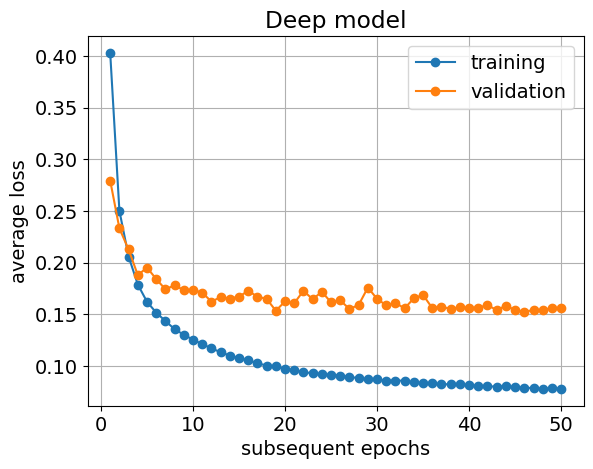

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=model_args['lr'],
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.308727
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.191521
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.011453
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.851148

Train set: Average loss: 1.1578
Validation set: Average loss: 0.3974, Accuracy: 8719/10000 (87%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.721687
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.757862
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.567294
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.582503

Train set: Average loss: 0.6671
Validation set: Average loss: 0.2496, Accuracy: 9237/10000 (92%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.716082
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.700781
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.629147
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.605445

Train set: Average loss: 0.5722
Validation set: Average loss: 0.1847, Accuracy: 9459/10000 (95%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.508046
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.635870
Train Epoch: 4 [25600/5

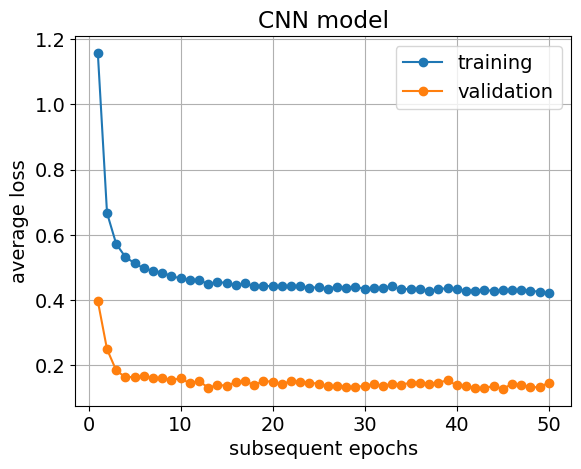

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'],
                      weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

In [10]:
class CNN2(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN2, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        # 4 kernels of size 5x5
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.flat = nn.Flatten()
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(4096, 250)
        self.fc2 = nn.Linear(250, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        # 2nd group
        x = self.conv2(x)
        x = F.max_pool2d(x, (3,3)) # downsizing each map to 12x12
        x = F.dropout(x, training=self.training)
        x = self.flat(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.386784
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.318873
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.382228
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.363805

Train set: Average loss: 0.4594
Validation set: Average loss: 0.1754, Accuracy: 9500/10000 (95%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.181319
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.261202
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.145153
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.084028

Train set: Average loss: 0.1543
Validation set: Average loss: 0.1016, Accuracy: 9710/10000 (97%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.095751
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.112156
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.086130
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.076822

Train set: Average loss: 0.1013
Validation set: Average loss: 0.0822, Accuracy: 9772/10000 (98%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.134737
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.105391
Train Epoch: 4 [25600/5

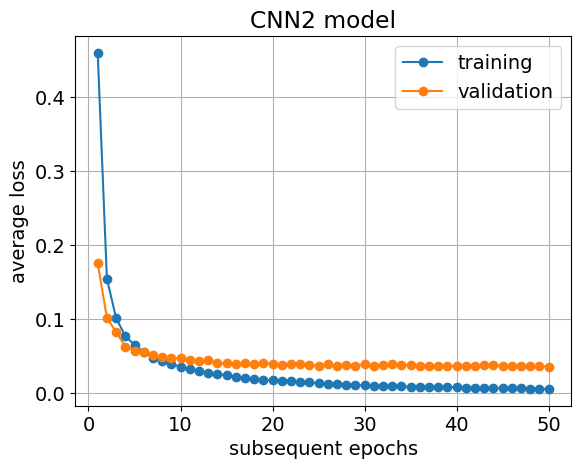

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN2().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN2 model')